In [13]:
import sys
# This on is a path correcting code, which is used to find the path of QuSim.
sys.path.append('../../..')
import QuSim.DataPlot.plot_lib as pl
import QuSim.Instruments.tools as tools
import QuSim.Instruments.stochastic_gen as sg
import QuSim.System.arb_qubit_system as aqs

import numpy as np
import matplotlib.pyplot as plt

from tqdm import *
from time import *
from sympy import*
import copy

from qutip import*

# Some useful tools
# Some intrinsic plotting function


def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Stochastic model
### Setup Hamiltonian

In [1]:
freq_list = [
    [0, 6.3],
    [0, 5.85]
]

inter_list = [
    {
        "v11": 1
    },
    {
        "v11": 1
    }
]

r_dic = {
    "r12": 0.05
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list = [
    {
        "v01": 0
    },
    {
        "v01": 50e-3
    }
]

driving_list = [
    {
        "W01": 0   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    }
]

bias_list = [ # Default, Z00 = 0
    {
        "Z11": 0
    },
    {
        "Z11": 0
    }
]

gamma_list = [
    {
        'up': 0,
        'down': 0,
        'z': 0
    },
    {
        'up': 0,
        'down': 0,
        'z': 0
    }
]


# gamma_list = None

_system_arb = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

NameError: name 'tools' is not defined

In [3]:
freq_list = [
    [0, 5.85]
]

inter_list = [
    {
        "v11": 1
    }
]

r_dic = {
    "r12": 1
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list = [
    {
        "V01": 0
    }
]

driving_list = [
    {
        "W01": 1
    }
]

bias_list = [ # Default, Z00 = 0
    {
        "Z11": 0
    }
]

gamma_list = [
    {
        'up': 0,
        'down': 0,
        'z': 0
    }
]


gamma_list = None

_system_arb = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

In [4]:
_system_arb.H

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.          0.        ]
 [ 0.         36.75663405]]

In [5]:
state_0, E_0, _ = _system_arb.get_eigenstates_energy((0,))
state_1, E_1, _ = _system_arb.get_eigenstates_energy((1,))

simulation_option = {
    "simulation_time": 100, # Unit in ns
    "simulation_step": 10000,
    "initial_state": [ket2dm(state_0), ket2dm(state_1)] # Do multiple simulation
}
# For density matrix, use qs.ket2dm(state_001)
pulse_sequence = [
    {
        'pulse_index': 0,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 20, # unit in ns
        't_width': 40, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_1 - E_0, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.05, # XY: Rabi freq; Z: biased frequency
        'q_index': 0 # 0, 1, 2
    }
]

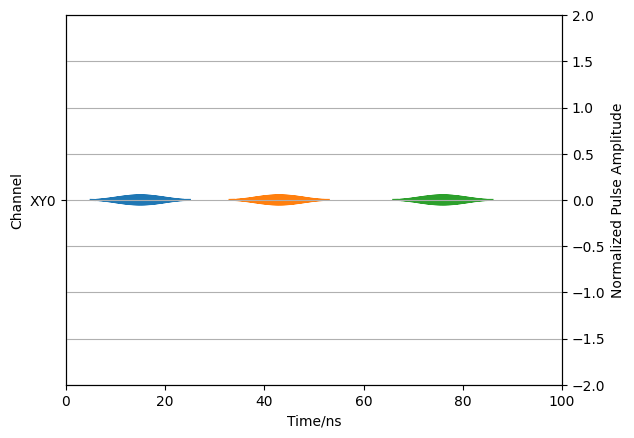

0

In [14]:
state_00, E_00, _ = _system_arb.get_eigenstates_energy((0,0))
state_01, E_01, _ = _system_arb.get_eigenstates_energy((0,1))

simulation_option = {
    "simulation_time": 100, # ns
    "simulation_step": 200000,
    "initial_state": [ket2dm(state_00)] # Do multiple simulation
}

dist_dic = {
    "freq_mean": E_01 - E_00, # GHz
    "freq_std": 0,
    "t_width_mean": 20, # ns
    "t_width_std": 0,
    "phase_mean": 0, # rad
    "phase_std": 0,
    "amplitude_mean": 0.05, # GHz 
    "amplitude_std": 0
}

t_switching_mean = 30 # ns
S, ilist = sg.gen_stochastic_point(simulation_option, t_switching_mean)
pulse_sequence = sg.gen_pulse_seq(S, ilist, dist_dic, "XY", "cosine", 0)

pulse_dic = {
        'pulse_index': 0,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 5, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0 , # unit in ns
        'freq': E_01 - E_00, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.05,
        'q_index': 0 # 0, 1, 2
    }

pulse_sequence.insert(0, pulse_dic)

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(copy.deepcopy(pulse_sequence), simulation_option)

In [15]:
result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)

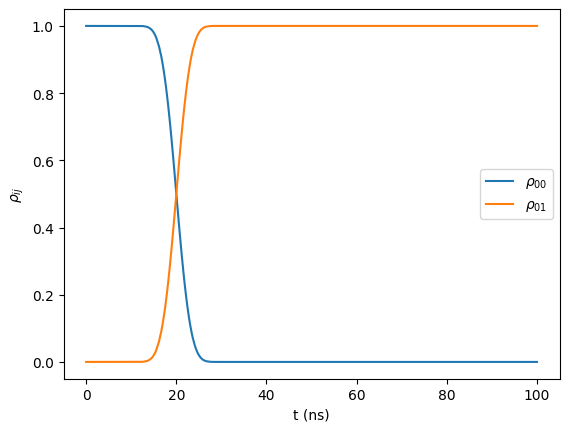

In [29]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline

plt.plot(t,aqs.expect(result.states, state_0 * aqs.dag(state_0)), label=r'$\rho_{00}$');

plt.plot(t,aqs.expect(result.states, state_1 * aqs.dag(state_1)), label=r'$\rho_{01}$');

plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

### Generate stochastic pulse sequence

In [16]:
_system_arb.H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.          0.31415927  0.          0.        ]
 [ 0.31415927 36.75663405  0.          0.        ]
 [ 0.          0.         39.58406744  0.31415927]
 [ 0.          0.          0.31415927 76.65486075]]

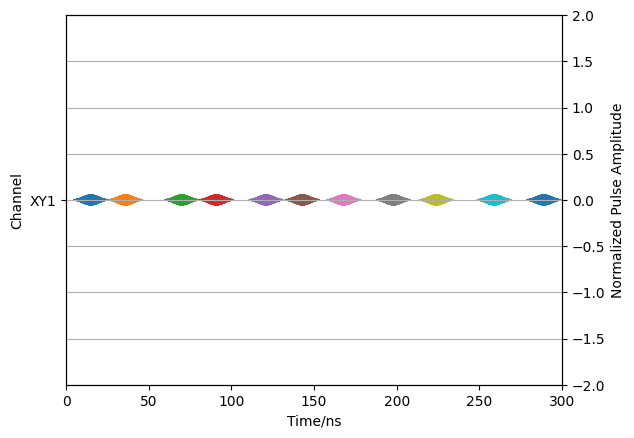

0

In [89]:
state_00, E_00, _ = _system_arb.get_eigenstates_energy((0,0))
state_01, E_01, _ = _system_arb.get_eigenstates_energy((0,1))
state_10, E_10, _ = _system_arb.get_eigenstates_energy((1,0))
state_11, E_11, _ = _system_arb.get_eigenstates_energy((1,1))

simulation_option = {
    "simulation_time": 300, # ns
    "simulation_step": 20000,
    "initial_state": [state_10] # Do multiple simulation
}

dist_dic = {
    "freq_mean": E_11 - E_10, # GHz
    "freq_std": 0,
    "t_width_mean": 20, # ns
    "t_width_std": 0,
    "phase_mean": 0, # rad
    "phase_std": 0,
    "amplitude_mean": 0.05, # GHz 
    "amplitude_std": 0
}

t_switching_mean = 25 # ns
S, ilist = sg.gen_stochastic_point(simulation_option, t_switching_mean)
pulse_sequence = sg.gen_pulse_seq(S, ilist, dist_dic, "XY", "cosine", 1)

pulse_dic = {
        'pulse_index': 0,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 5, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0 , # unit in ns
        'freq': E_01 - E_00, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.05,
        'q_index': 1 # 0, 1, 2
    }

pulse_sequence.insert(0, pulse_dic)

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(copy.deepcopy(pulse_sequence), simulation_option)

### Solve master equation

In [190]:
pulse_sequence = [
    {
        'pulse_index': 0,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 11, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_01 - E_00, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.05, # XY: Rabi freq; Z: biased frequency
        'q_index': 1 # 0, 1, 2
    },
    {
        'pulse_index': 1,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 50, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_01 - E_00, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.05, # XY: Rabi freq; Z: biased frequency
        'q_index': 1 # 0, 1, 2
    },
    {
        'pulse_index': 2,
        'type': "XY", # 'XY' or 'Z'
        'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
        't_delay': 79, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_01 - E_00, # unit in GHz; Z pulse does not use it
        'pulse_detuning': 0,
        'phase': 0, # unit in rad;
        'amplitude': 0.05, # XY: Rabi freq; Z: biased frequency
        'q_index': 1 # 0, 1, 2
    }
]

In [90]:
result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)

In [100]:
def get_angle(tstate, spt):
    if isket(spt):
        if isket(tstate):
            angle = np.angle(tstate.dag() * spt)[0][0]
    else:
        if isket(tstate):
            length = spt.dims[0][0]
            # print(length)
            # print(tstate.dims)
            # print(Qobj(np.insert(np.angle(spt.full()[0][1:length]), 0 ,0)).dims)
            angle_qobj = Qobj(np.insert(np.angle(spt.full()[0][1:length]), 0 ,0)).dag() * tstate
            angle = angle_qobj.full()[0][0]
        else: angle = None
    return angle

def phase_tracking(res, state):
    angle_list = []
    for spt in res.states:
        angle_list.append(get_angle(state, spt))
    return angle_list

res = result_list[0]
angle_list = phase_tracking(res, state_11)

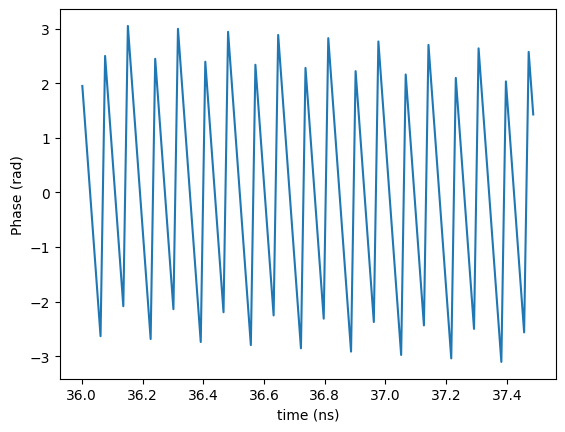

In [104]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])
# plt.plot(t[3260:4260], angle_list[3260:4260])
plt.plot(t[2400:2500], angle_list[2400:2500])
plt.xlabel('time (ns)')
plt.ylabel('Phase (rad)')
plt.show()

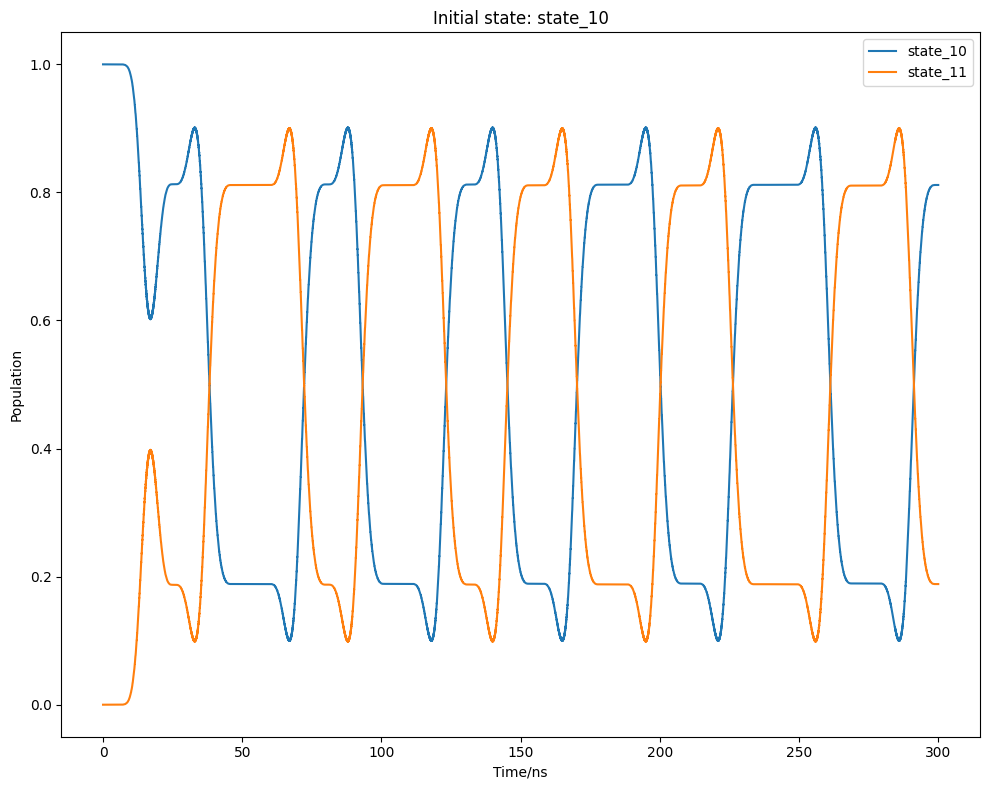

0

In [93]:
# state that you want to plot each simulation
interested_state = [
                    [state_10,state_11]
                    ]
# Convert the variable name to string in order to make legend in the plot
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

# plot state population evolution
pl.plot_population_evolution(_system_arb, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

In [91]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline

plt.plot(t,aqs.expect(result.states, state_11 * aqs.dag(state_11)), label=r'$\rho_{33}$');

plt.plot(t,aqs.expect(result.states, state_10 * aqs.dag(state_10)), label=r'$\rho_{22}$');

plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

TypeError: Invalid operand types

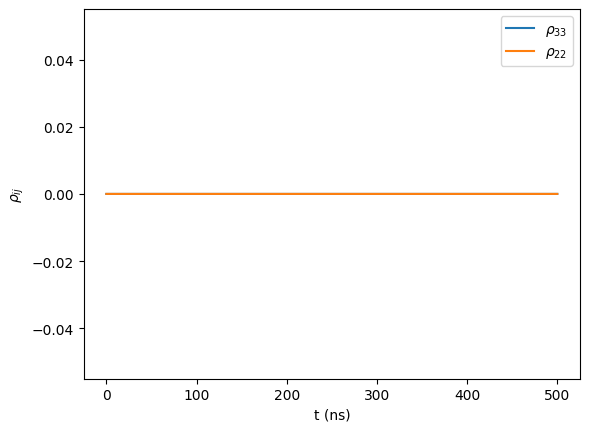

In [661]:
# Plot
%matplotlib inline

plt.plot(t,aqs.expect(result.states, state_11 * aqs.dag(state_11)), label=r'$\rho_{33}$');

plt.plot(t,aqs.expect(result.states, state_01 * aqs.dag(state_01)), label=r'$\rho_{22}$');

plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns)")
plt.legend()
plt.show()

In [585]:
result.states[-1]

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

#### Draft angle list function

In [219]:
angle_list[0]

array([[-3.14159115, -1.30012542,  3.14159265, -1.30013893]])

In [278]:
import numpy as np

# Sample column array
column_array = np.array([1, 2, 3, 4, 5])

# Convert the column array to a row array
row_array = column_array.reshape(1, -1)

# Alternatively, you can use transpose or reshape with order='F' (Fortran-style)
# row_array = column_array[np.newaxis, :]
# row_array = column_array.reshape(1, -1, order='F')

# Print the result
print("Column Array:")
print(column_array)
print("\nRow Array:")
print(row_array)

Column Array:
[1 2 3 4 5]

Row Array:
[[1 2 3 4 5]]


In [549]:
def get_angle(tstate, spt):
    if isket(spt):
        if isket(tstate):
            angle = np.angle(tstate.dag() * spt)
    else:
        if isket(tstate):
            length = spt.dims[0][0]
            # print(length)
            # print(tstate.dims)
            # print(Qobj(np.insert(np.angle(spt.full()[0][1:length]), 0 ,0)).dims)
            angle_qobj = Qobj(np.insert(np.angle(spt.full()[0][1:length]), 0 ,0)).dag() * tstate
            angle = angle_qobj.full()[0]
        else: angle = None
    return angle


In [550]:
# Complex coefficients for the superposition state
alpha = complex(0.7, 0.3)  # Coefficient for |0>
beta = complex(0.4, -0.2)  # Coefficient for |1>

# Create the superposition state
sst = alpha * basis(5, 0) + beta * basis(5, 4)


In [551]:
get_angle(basis(5, 4), ket2dm(sst))

array([0.8685394+0.j])

In [552]:
np.angle(beta)

-0.4636476090008061

In [283]:
np.angle(alpha)

0.40489178628508343

## Island model

### Hamiltonian

Condsider a small piece of metal island existing on the surface of the Si cap, which is close to the quantum dot region and the plunger gate. The intrinsic Hamiltonian of the island can be modulated by a small capacitor

$$
H_{charge} = \frac{(Q - Q_0)^2}{2C_\Sigma} = E_C (\hat{n} - n_0)^2
$$
where the charge energy is given by $E_C = e^2/2C_\Sigma$ and the quantized charge operator on the island is defined as $\hat{n}_n = Q/e$.

The coupling between the charge island and the ST0 qubit can be modulated as

$$
H_{int} = \chi \sigma_z \hat{n}
$$

The qubit-charge TLF Hamiltonian looks like

$$
H = H_q + H_{charge} + H_{int}
$$

In [34]:
n0 = 0; num_charge_level = 3; n_rng = np.linspace(n0, n0+num_charge_level-1, num_charge_level, dtype=int); 
echarge = 1.602 * 10**(-19); C_sigma = 10*10**(-18) # Unit in F
# EC = echarge**2/2/C_sigma
kb = 1.381 * 10**(-23) # J/K; 
hplank = 6.626 * 10**(-34) # J/Hz
T = 0.1 # Unit K
EC = kb*T/hplank * 10**(-9)
EC

2.0842137035919106

In [138]:
freq_list = [ # GHz
    [0, 11],
    [EC*ii**2 for ii in n_rng],
]

inter_list = [
    {
        "v01": 0,
        "v00": 0,
        "v11": 1
    },
    {
        "v01": 0,
        "v00": n_rng[0],
        "v11": n_rng[1],
        "v22": n_rng[2]
    }
]

r_dic = {
    "r12": 30*10**(-3)
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list=None
## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j * np.sqrt(1),
        "W12": 1j * np.sqrt(2),
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 0,
        "Z22": 0
    }
]

gamma_list = None

# gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_00, E_00, index_00 = _system_arb1.get_eigenstates_energy((0,0))

state_01, E_01, index_01 = _system_arb1.get_eigenstates_energy((0,1))
state_10, E_10, index_10 = _system_arb1.get_eigenstates_energy((1,0))

state_11, E_11, index_11 = _system_arb1.get_eigenstates_energy((1,1))
state_02, E_02, index_02 = _system_arb1.get_eigenstates_energy((0,2))

state_12, E_12, index_12 = _system_arb1.get_eigenstates_energy((1,2))

_system_arb1.H_inter

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.03 0.  ]
 [0.   0.   0.   0.   0.   0.06]]

### Pulse modulation
For cosine envelope, the rotating angle $\theta_{ij}$ between two levels with index $i$ and $j$ has the following relation
$$
\frac{\theta_{ij}}{\pi} =  |V_{D, ij}| A t_g
$$
where $A$ the amplitude, $t_g = t_w$ is the `t_width`, and $|V_{D,ij}|$ is the XY drive matrix element of the corresponding two levels.

In [139]:
tg = 10; v_c = np.sqrt(2)
amp = 1/(v_c* tg)
amp

0.07071067811865475

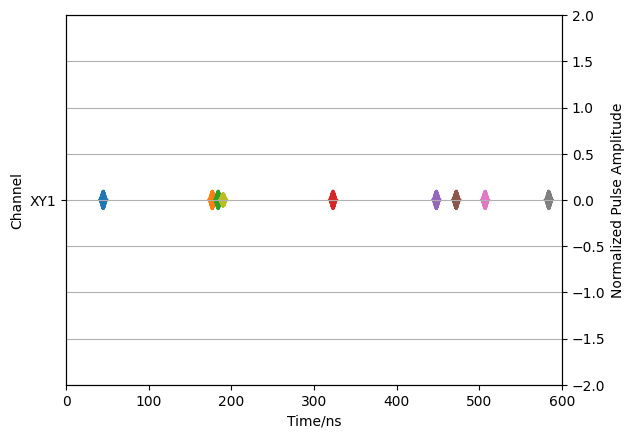

0

In [160]:
simulation_option = {
    "simulation_time": 600, # ns
    "simulation_step": 100000,
    "initial_state": [state_11] # Do multiple simulation
}

dist_dic = {
    "freq_mean": E_12 - E_11, # GHz
    "freq_std": 0,
    "t_width_mean": tg, # ns
    "t_width_std": 0,
    "phase_mean": 0, # rad
    "phase_std": 0,
    "amplitude_mean": amp, #0.0250505, # GHz 
    "amplitude_std": 0
}

t_switching_mean = 55 # ns
p_switch = 0.01
S, ilist = sg.gen_rt_point(simulation_option, p_switch)
pulse_sequence = sg.gen_pulse_seq(S, ilist, dist_dic, "XY", "cosine", 1)

dist_dic2 = {
    "freq_mean": E_11 - E_10, # GHz
    "freq_std": 0,
    "t_width_mean": 10, # ns
    "t_width_std": 0,
    "phase_mean": 0, # rad
    "phase_std": 0,
    "amplitude_mean": 0.1, #0.0250505, # GHz 
    "amplitude_std": 0
}
p_switch = 0.01
S2, ilist2 = sg.gen_rt_point(simulation_option, p_switch)
ps2 = sg.gen_pulse_seq(S2, ilist2, dist_dic2, "XY", "cosine", 1)
for pss in ps2:
    pulse_sequence.insert(-1, pss)

# pulse_dic = {
#         'pulse_index': 0,
#         'type': "XY", # 'XY' or 'Z'
#         'pulse_shape': "cosine", # See PulseGen/pulse_shape.py
#         't_delay': 5, # unit in ns
#         't_width': 20, # unit in ns
#         't_plateau': 0 , # unit in ns
#         'freq': E_11 - E_10, # unit in GHz; Z pulse does not use it
#         'pulse_detuning': 0,
#         'phase': 0, # unit in rad;
#         'amplitude': 0.05,
#         'q_index': 1 # 0, 1, 2
#     }

# pulse_sequence.insert(0, pulse_dic)

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(copy.deepcopy(pulse_sequence), simulation_option)

In [150]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)

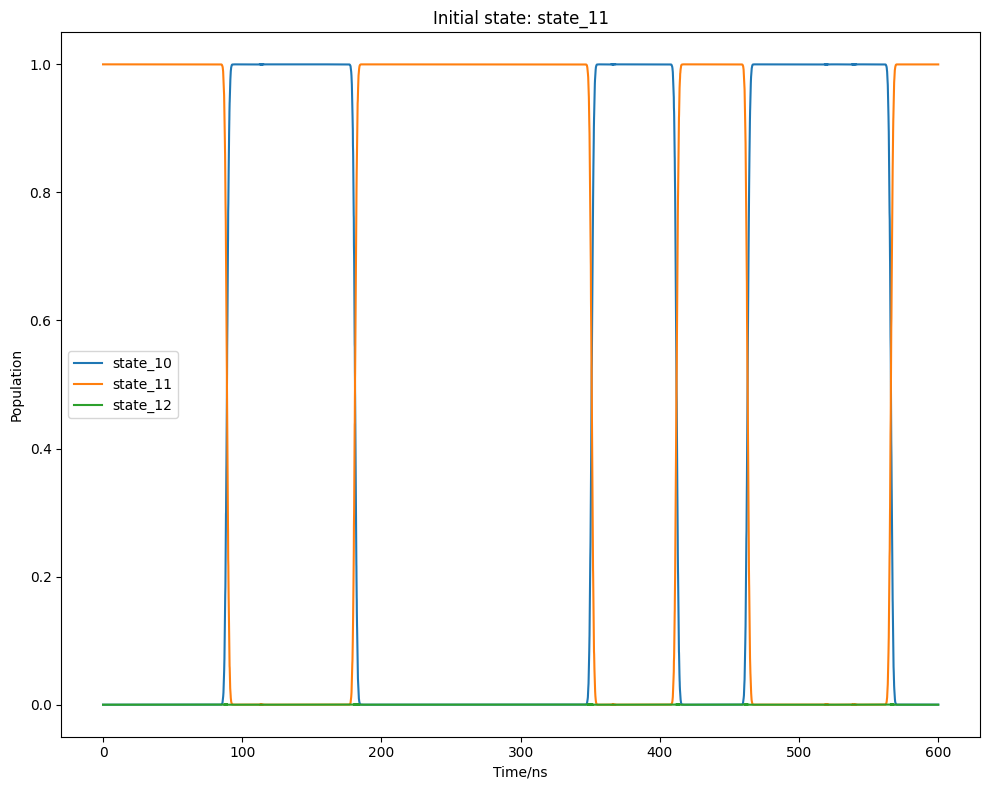

0

In [151]:
# state that you want to plot each simulation
interested_state = [
                    [state_10, state_11, state_12]
                    # [state_10, state_11, state_12],
                    # [state_10, state_11, state_12]
                    ]
# Convert the variable name to string in order to make legend in the plot
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])
%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system_arb1, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

In [152]:
np.abs((state_11.dag() * _system_arb1.H * result_list[0].states[-1]).data[0,0])/2/np.pi

13.113462492054207

In [153]:
np.abs((rss.dag() * _system_arb1.H_0 * ss).data[0,0])
state_12.dag() *_system_arb1.H_inter * state_12

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.06]]

In [154]:
pop_list1 = []; pop_list2 = [];
for ii, ss in enumerate(interested_state[0]):
    dummy_list1 = []; dummy_list2 = []
    for rss in result_list[0].states:
        inner_prod = np.abs((rss.dag() * ss).data[0,0])
        # E_total = np.abs((rss.dag() * _system_arb1.H * ss ).data[0,0]) - freq_list[1][ii]*2*np.pi
        exp_charge_num = np.abs((rss.dag() * _system_arb1.H_inter * ss).data[0,0])#/2/np.pi - freq_list[0][1] - freq_list[1][ii]
        if inner_prod < 0.5: val = 0
        else: val = 1
        dummy_list1.append(val); dummy_list2.append(exp_charge_num)
    pop_list1.append(np.array(dummy_list1) * (ii +1))
    # pop_list2.append(np.array(dummy_list2))
    pop_list2.append(np.array(dummy_list2) )
signal_arr1 = np.array(pop_list1).sum(axis=0)
signal_arr2 = np.array(pop_list2).sum(axis=0) + freq_list[0][1]

In [155]:
signal_arr2 = []; signal_arr1 = []
for ii in range(simulation_option["simulation_step"]):
    candi_list1 = [pop_list1[k][ii] for k in range(3)]
    candi_list2 = [pop_list2[k][ii] for k in range(3)]
    signal_arr1.append(np.max(candi_list1))
    signal_arr2.append(np.max(candi_list2))

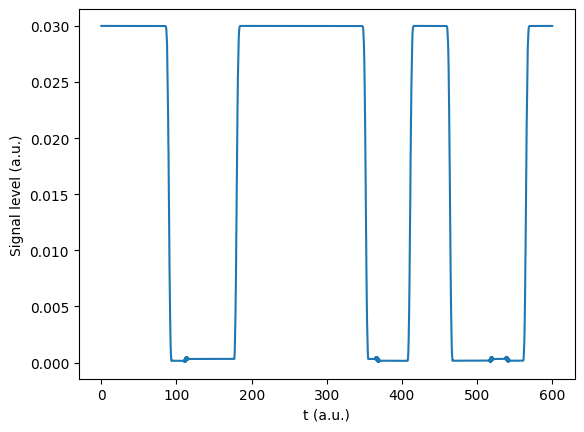

In [156]:
tlist = np.linspace(0, simulation_option["simulation_time"], simulation_option["simulation_step"])
plt.plot(tlist, signal_arr2)
plt.xlabel("t (a.u.)")
plt.ylabel("Signal level (a.u.)")
plt.show()

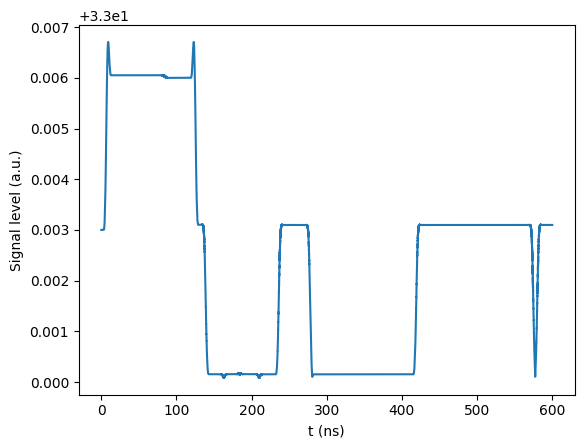

In [377]:
tlist = np.linspace(0, simulation_option["simulation_time"], simulation_option["simulation_step"])
plt.plot(tlist, signal_arr2)
plt.xlabel("t (ns)")
plt.ylabel("Signal level (a.u.)")
plt.show()